<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#IMPACT-OF-COVID-19-PANDEMIC-ON-AIR-QUALITY" data-toc-modified-id="IMPACT-OF-COVID-19-PANDEMIC-ON-AIR-QUALITY-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>IMPACT OF COVID-19 PANDEMIC ON AIR QUALITY</a></span><ul class="toc-item"><li><span><a href="#Air-quality-Data-Exploration-and-Cleanup" data-toc-modified-id="Air-quality-Data-Exploration-and-Cleanup-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Air quality Data Exploration and Cleanup</a></span><ul class="toc-item"><li><span><a href="#Import-datasets-and-overview-of-the-air-quality-data" data-toc-modified-id="Import-datasets-and-overview-of-the-air-quality-data-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Import datasets and overview of the air quality data</a></span></li><li><span><a href="#Slice-and-dice-the-data" data-toc-modified-id="Slice-and-dice-the-data-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Slice and dice the data</a></span></li><li><span><a href="#Overview-of-the-value-distribution-of-the-major-air-pollutants" data-toc-modified-id="Overview-of-the-value-distribution-of-the-major-air-pollutants-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Overview of the value distribution of the major air pollutants</a></span></li><li><span><a href="#Visualise-air-quality-change-in-Australia-(Melbourne,-Sydney-and-Perth)-in-2019-2020H1" data-toc-modified-id="Visualise-air-quality-change-in-Australia-(Melbourne,-Sydney-and-Perth)-in-2019-2020H1-1.1.4"><span class="toc-item-num">1.1.4&nbsp;&nbsp;</span>Visualise air quality change in Australia (Melbourne, Sydney and Perth) in 2019-2020H1</a></span></li><li><span><a href="#Visualise-air-quality-change-in-India-(Mumbai,-Delhi,-Hyderabad)-in-2019-2020H1" data-toc-modified-id="Visualise-air-quality-change-in-India-(Mumbai,-Delhi,-Hyderabad)-in-2019-2020H1-1.1.5"><span class="toc-item-num">1.1.5&nbsp;&nbsp;</span>Visualise air quality change in India (Mumbai, Delhi, Hyderabad) in 2019-2020H1</a></span></li></ul></li><li><span><a href="#COVID-19-in-AUSTRALIA-DATA-EXPLORATION-AND-CLEAN-UP" data-toc-modified-id="COVID-19-in-AUSTRALIA-DATA-EXPLORATION-AND-CLEAN-UP-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>COVID-19 in AUSTRALIA DATA EXPLORATION AND CLEAN UP</a></span></li><li><span><a href="#COVID-19-DATA-EXPLORATION-AND-CLEAN-UP" data-toc-modified-id="COVID-19-DATA-EXPLORATION-AND-CLEAN-UP-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>COVID-19 DATA EXPLORATION AND CLEAN UP</a></span></li></ul></li></ul></div>

# IMPACT OF COVID-19 PANDEMIC ON AIR QUALITY

## Air quality Data Exploration and Cleanup

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import json
from pprint import pprint
from scipy.stats import linregress

"https://aqicn.org/data-platform/covid19/
With the COVID-19 spreading out all over the world, the World Air Quality Index project team saw a surge in requests for global data covering the whole world map. As a result, the WAQI project is now providing a new dedicated data-set, updated 3 times a day, and covering about 380 major cities in the world, from January 2020 until now.

The data for each major cities is based on the average (median) of several stations. The data set provides min, max, median and standard deviation for each of the air pollutant species (PM2.5,PM10, Ozone ...) as well as meteorological data (Wind, Temperature, ...). All air pollutant species are converted to the US EPA standard (i.e. no raw concentrations). All dates are UTC based. The count column is the number of samples used for calculating the median and standard deviation."

### Import datasets and overview of the air quality data

In [2]:
periods = ["2020", "2019Q1", "2019Q2", "2019Q3", "2019Q4"]

df_list = list()

for period in periods:
    path = f"historical_data/waqi-covid19-airqualitydata-{period}.csv"
    df = pd.read_csv(path)
    df_list.append(df)

In [3]:
airdf_2019_2020 = pd.concat(df_list, ignore_index=True)

In [4]:
airdf_2019_2020.head()

,Date,Country,City,Specie,count,min,max,median,variance
0,31/05/2020,IR,Isfahan,temperature,120,17.5,35.0,27.5,331.51
1,13/06/2020,IR,Isfahan,temperature,144,16.0,36.5,27.5,488.74
2,3/07/2020,IR,Isfahan,temperature,67,19.0,33.0,24.0,128.08
3,28/03/2020,IR,Isfahan,temperature,240,3.0,14.0,9.5,136.68
4,23/04/2020,IR,Isfahan,temperature,168,6.0,25.5,16.0,400.79


### Slice and dice the data

In [5]:
# Display an overview of the Specie column
airdf_2019_2020["Specie"].unique()

array(['temperature', 'wind-speed', 'wind-gust', 'dew', 'pm25',
       'humidity', 'wind speed', 'pressure', 'wind gust', 'co', 'so2',
       'precipitation', 'no2', 'pm10', 'o3', 'aqi', 'pol', 'uvi', 'wd',
       'neph', 'mepaqi', 'pm1'], dtype=object)

In [6]:
airdf_2019_2020["Specie"].value_counts()

temperature      310236
humidity         310145
pressure         308517
pm25             270688
no2              266793
pm10             264859
wind-speed       263292
o3               250438
so2              226576
dew              226147
co               203776
wind-gust        172805
wind speed        47002
wind gust         29576
precipitation     26825
wd                25720
aqi                8267
uvi                5632
pol                3790
pm1                1380
mepaqi              564
neph                440
Name: Specie, dtype: int64

> We understand that "Air movements influence the fate of air pollutants. So any study of air pollution should include a study of the local weather patterns (meteorology). If the air is calm and pollutants cannot disperse, then the concentration of these pollutants will build up. On the other hand, when strong, turbulent winds blow, pollutants disperse quickly, resulting in lower pollutant concentrations." https://www.qld.gov.au/environment/pollution/monitoring/air/air-monitoring/meteorology-influence/meteorology-factors#:~:text=Meteorological%20factors-,Meteorological%20factors,these%20pollutants%20will%20build%20up.
Hence the Meteorology parameters like temperature, humidity, pressure, wind speed, to name a few, should have some sorts of correlations with the air quality.
(http://www.bom.gov.au/vic/observations/melbourne.shtml)

> However, due to the scope of our project, we'll only focus on air pollutant parameters to assess their changes before COVID-19 and 6 months into the pandemic. We're not trying to explain the causes of air quality change. Hence, we'll remove data related to the following meteorology-related species: **temperature, humidity, pressure, wind-speed, dew, wind-gust, wind speed, wind gust, precipitation, wd (wind direction), uvi**.
https://aqicn.org/publishingdata/

> We'll also remove species with the least number of available data points  including **aqi, pol, pm1, mepaqi, neph**.

In [7]:
species_to_remove = ["temperature", "humidity", "pressure", "wind-speed", "dew", "wind-gust",
                     "wind speed", "wind gust", "precipitation", "wd", "aqi", "uvi", "pol", "pm1", "mepaqi", "neph"]

clean_airdf = airdf_2019_2020[~airdf_2019_2020["Specie"].isin(
    species_to_remove)].reset_index(drop=True).copy()

In [8]:
clean_airdf.head()

,Date,Country,City,Specie,count,min,max,median,variance
0,24/02/2020,IR,Isfahan,pm25,129,54.0,194.0,126.0,10921.40
1,7/05/2020,IR,Isfahan,pm25,168,17.0,168.0,91.0,14014.00
2,28/05/2020,IR,Isfahan,pm25,127,17.0,115.0,72.0,3558.56
3,20/02/2020,IR,Isfahan,pm25,113,26.0,181.0,76.0,11209.80
4,23/02/2020,IR,Isfahan,pm25,132,22.0,132.0,76.0,3209.67


In [9]:
clean_airdf["Specie"].value_counts()

pm25    270688
no2     266793
pm10    264859
o3      250438
so2     226576
co      203776
Name: Specie, dtype: int64

More about AQI:
https://www.airnow.gov/aqi/aqi-basics/
https://www.airnow.gov/sites/default/files/2020-05/aqi-technical-assistance-document-sept2018.pdf
"Five major pollutants:
EPA establishes an AQI for five major air pollutants regulated by the Clean Air Act. Each of these pollutants has a national air quality standard set by EPA to protect public health:

* Ground-level ozone **o3** (ppm - parts per million)
* Particulate Matter - including PM2.5 **pm25** and PM10 **pm10** (μg/m3)
* Carbon Monoxide **co** (ppm)
* Sulfur Dioxide **so2** (ppb - parts per billion)
* Nitrogen Dioxide **no2** (ppb)

https://en.wikipedia.org/wiki/Air_pollution

"https://waqi.info/
The Air Quality Index is based on measurement of particulate matter (PM2.5 and PM10), Ozone (O3), Nitrogen Dioxide (NO2), Sulfur Dioxide (SO2) and Carbon Monoxide (CO) emissions. Most of the stations on the map are monitoring both PM2.5 and PM10 data, but there are few exceptions where only PM10 is available.

All measurements are based on hourly readings: For instance, an AQI reported at 8AM means that the measurement was done from 7AM to 8AM.
More details https://aqicn.org/faq/


https://www.weatherbit.io/api/airquality-history#:~:text=Air%20Quality%20API%20(Historical),an%20air%20quality%20index%20score.

aqi: Air Quality Index [US - EPA standard 0 - +500]
o3: Concentration of surface O3 (µg/m³)
so2: Concentration of surface SO2 (µg/m³)
no2: Concentration of surface NO2 (µg/m³)
co: Concentration of carbon monoxide (µg/m³)
pm25: Concentration of particulate matter < 2.5 microns (µg/m³)
pm10: Concentration of particulate matter < 10 microns (µg/m³)

Some good info on air pollution impacts https://ourworldindata.org/air-pollution
https://www.who.int/health-topics/air-pollution#tab=tab_1
https://www.epa.vic.gov.au/for-community/airwatch
https://www.kaggle.com/frtgnn/clean-air-india-s-air-quality/data

In [10]:
clean_airdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1483130 entries, 0 to 1483129
Data columns (total 9 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Date      1483130 non-null  object 
 1   Country   1483130 non-null  object 
 2   City      1483130 non-null  object 
 3   Specie    1483130 non-null  object 
 4   count     1483130 non-null  int64  
 5   min       1483130 non-null  float64
 6   max       1483130 non-null  float64
 7   median    1483130 non-null  float64
 8   variance  1483130 non-null  float64
dtypes: float64(4), int64(1), object(4)
memory usage: 101.8+ MB


We can see that the Date column is of generic object type. Since we want to perform some time related analysis on this data, we need to convert it to a datetime format. Let’s use to_datetime() function to convert the Date column into a datetime object. 

In [11]:
clean_airdf["Date"] = pd.to_datetime(clean_airdf["Date"], format="%d/%m/%Y")

In [12]:
clean_airdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1483130 entries, 0 to 1483129
Data columns (total 9 columns):
 #   Column    Non-Null Count    Dtype         
---  ------    --------------    -----         
 0   Date      1483130 non-null  datetime64[ns]
 1   Country   1483130 non-null  object        
 2   City      1483130 non-null  object        
 3   Specie    1483130 non-null  object        
 4   count     1483130 non-null  int64         
 5   min       1483130 non-null  float64       
 6   max       1483130 non-null  float64       
 7   median    1483130 non-null  float64       
 8   variance  1483130 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(3)
memory usage: 101.8+ MB


In [13]:
# Find the earliest date the air quality dataset covers:
starting_date = clean_airdf["Date"].min()
starting_date

Timestamp('2018-12-31 00:00:00')

In [14]:
# Find the latest date the air quality dataset covers:
end_date = clean_airdf["Date"].max()
end_date

Timestamp('2020-07-03 00:00:00')

In [15]:
# Display an overview of the Country column
clean_airdf["Country"].unique()

array(['IR', 'TJ', 'BR', 'CN', 'DK', 'ES', 'ML', 'SK', 'XK', 'CL', 'DE',
       'KW', 'MM', 'PH', 'PK', 'PL', 'RU', 'SE', 'SG', 'AE', 'BA', 'CZ',
       'ID', 'IS', 'MO', 'RO', 'AR', 'AU', 'EC', 'GH', 'HK', 'PE', 'UA',
       'EE', 'FR', 'JP', 'MN', 'FI', 'IE', 'IL', 'KZ', 'LA', 'UZ', 'BD',
       'BE', 'GR', 'KR', 'LK', 'MK', 'MX', 'TR', 'AF', 'AT', 'GT', 'BO',
       'CR', 'JO', 'PR', 'SA', 'SV', 'CA', 'IT', 'NO', 'RE', 'TM', 'ZA',
       'BH', 'LT', 'TH', 'BG', 'CH', 'HU', 'NL', 'NZ', 'UG', 'VN', 'ET',
       'GE', 'GN', 'IQ', 'RS', 'TW', 'CI', 'CO', 'CY', 'DZ', 'HR', 'IN',
       'KG', 'CW', 'GB', 'NP', 'PT', 'US'], dtype=object)

In [16]:
country_airdata_df = pd.DataFrame(clean_airdf["Country"].unique(), columns=["country_code"])
country_airdata_df

,country_code
0,IR
1,TJ
2,BR
3,CN
4,DK
...,...
89,CW
90,GB
91,NP
92,PT


There are 94 countries in the dataframe, including Australia (AU)....

In [17]:
# Display an overview of the City column
clean_airdf["City"].unique()

array(['Isfahan', 'Arāk', 'Karaj', 'Qom', 'Orūmīyeh', 'Yazd', 'Īlām',
       'Kerman', 'Khorramshahr', 'Tabriz', 'Bandar Abbas', 'Sanandaj',
       'Kermanshah', 'Khorramabad', 'Shiraz', 'Zanjān', 'Mashhad',
       'Tehran', 'Dushanbe', 'São José dos Campos', 'Vitória',
       'São Paulo', 'Beijing', 'Jieyang', 'Kunming', 'Hangzhou',
       'Chongqing', 'Qingdao', 'Haikou', 'Ürümqi', 'Qiqihar', 'Guiyang',
       'Shenzhen', 'Yunfu', 'Xuchang', 'Yinchuan', 'Shenyang', 'Lhasa',
       'Shanghai', 'Changchun', 'Foshan', 'Nanning', 'Fushun', 'Hefei',
       'Chengdu', 'Hohhot', 'Qinhuangdao', 'Shijiazhuang', 'Shantou',
       'Zhengzhou', 'Nanjing', 'Xining', 'Xi’an', 'Zhuzhou', 'Wuhan',
       'Tianjin', 'Changzhou', 'Nanchang', 'Shiyan', 'Xinxiang', 'Suzhou',
       'Harbin', 'Lanzhou', 'Jinan', 'Changsha', 'Hegang', 'Anyang',
       'Wuxi', 'Taiyuan', 'Guangzhou', 'Fuzhou', 'Ningbo', 'Xiamen',
       'Dongguan', 'Copenhagen', 'Las Palmas de Gran Canaria',
       'Salamanca', 'Barcelona'

In [18]:
clean_airdf["City"].value_counts()

London          5075
Taoyuan City    3390
Hsinchu         3390
Shijiazhuang    3390
Nanchang        3390
                ... 
Almaty           132
Conakry          115
Abidjan          115
Accra             97
Zamboanga         60
Name: City, Length: 602, dtype: int64

There are 602 cities in our dataframe. Let's see what cities in Australia covered in the dataset.

In [19]:
clean_airdf.loc[clean_airdf["Country"]=="AU", "City"].value_counts()

Sydney        3364
Brisbane      3348
Melbourne     3284
Wollongong    3253
Darwin        3208
Adelaide      3133
Perth         3082
Newcastle     2871
Launceston    1126
Hobart        1126
Canberra      1093
Name: City, dtype: int64

### Overview of the value distribution of the major air pollutants

In [20]:
clean_airdf.head()

,Date,Country,City,Specie,count,min,max,median,variance
0,2020-02-24,IR,Isfahan,pm25,129,54.0,194.0,126.0,10921.40
1,2020-05-07,IR,Isfahan,pm25,168,17.0,168.0,91.0,14014.00
2,2020-05-28,IR,Isfahan,pm25,127,17.0,115.0,72.0,3558.56
3,2020-02-20,IR,Isfahan,pm25,113,26.0,181.0,76.0,11209.80
4,2020-02-23,IR,Isfahan,pm25,132,22.0,132.0,76.0,3209.67


In [21]:
specie_list = clean_airdf["Specie"].unique().tolist()
specie_list

['pm25', 'co', 'so2', 'no2', 'pm10', 'o3']

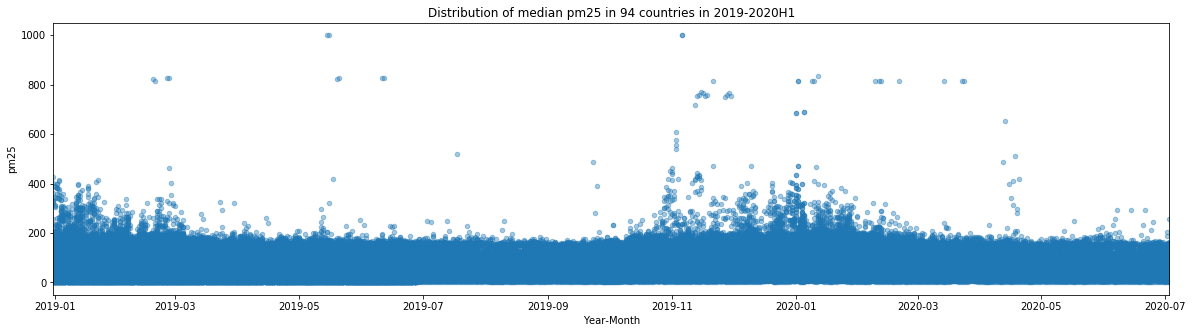

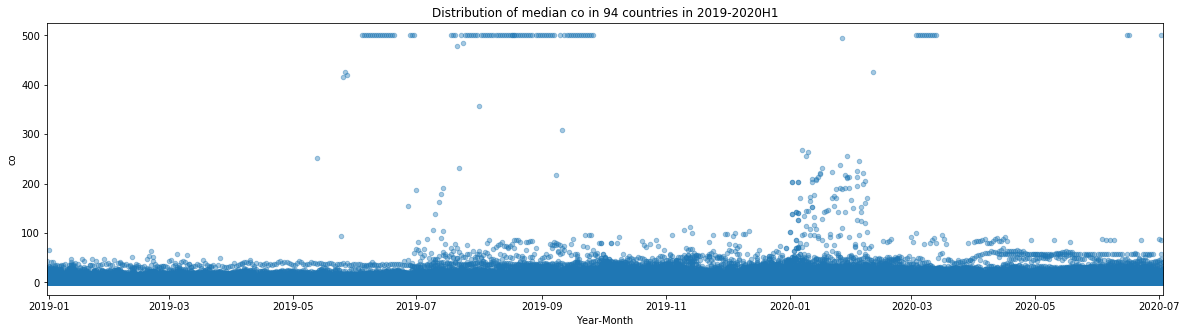

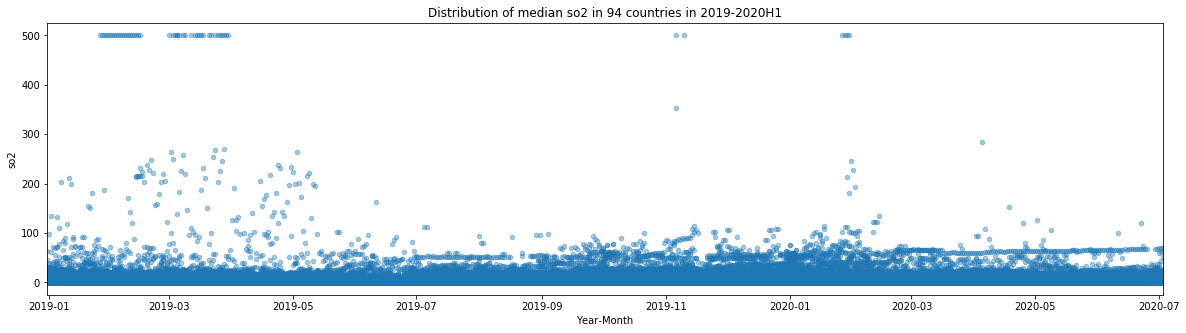

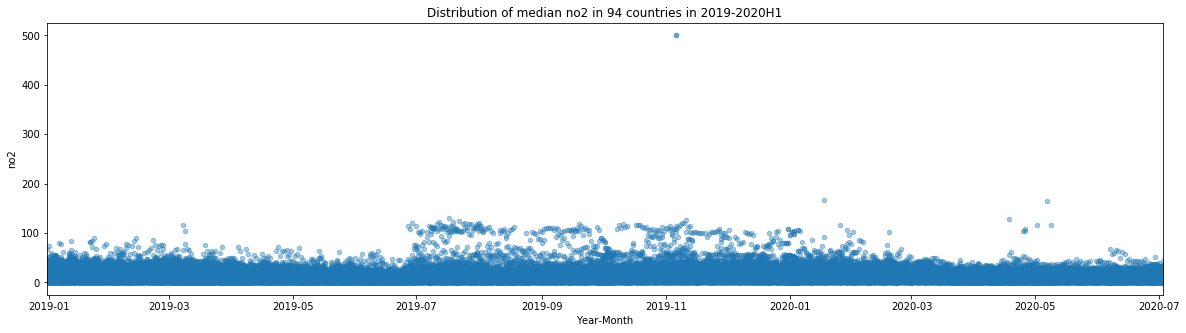

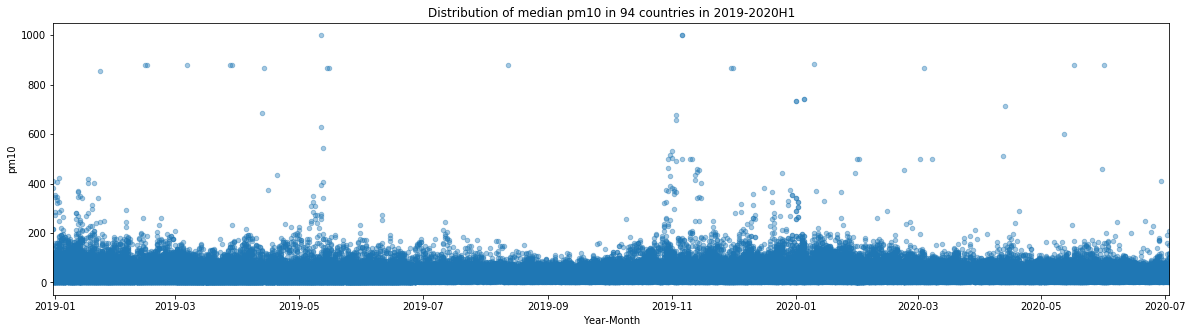

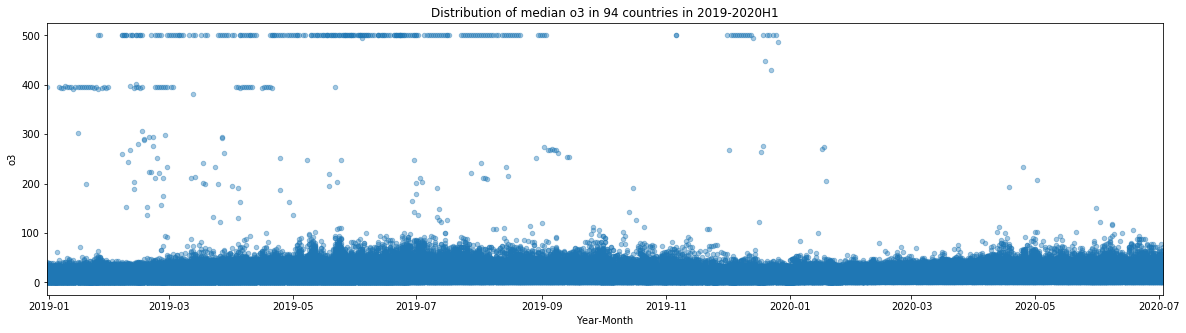

In [22]:
for specie in specie_list:
    clean_airdf_specie = clean_airdf[clean_airdf["Specie"] == specie]
    ax = clean_airdf_specie.plot.scatter(x="Date", y="median", alpha=0.4, figsize=(
        20, 5), title=f"Distribution of median {specie} in 94 countries in 2019-2020H1")
    ax.set_xlabel("Year-Month")
    ax.set_ylabel(specie)
    ax.set_xlim(starting_date, end_date)

> **As we can see from above charts, there are quite a few extreme values in the the median measurements of the 6 air pollutants. However, due to our time and knowledge limitation regarding the air pollutants, we'll not remove any extreme values. We'd like to draw anyone with domain knowledge to this issue. Any should-be-removed outliers would have some impact on our following analysis.**

### Visualise air quality change in Australia (Melbourne, Sydney and Perth) in 2019-2020H1

* **Let's explore how air quality change in Melbourne, Victoria.**

In [23]:
mel_air_df = clean_airdf.loc[(clean_airdf["Country"] == "AU") & (
    clean_airdf["City"] == "Melbourne")].sort_values("Date").set_index("Date")
mel_air_df.head()

,Country,City,Specie,count,min,max,median,variance
Date,,,,,,,,
2018-12-31,AU,Melbourne,pm25,174,1.0,41.0,28.0,989.20
2018-12-31,AU,Melbourne,pm10,140,2.0,31.0,18.0,505.25
2018-12-31,AU,Melbourne,so2,33,1.5,2.9,1.5,3.01
2018-12-31,AU,Melbourne,o3,132,7.3,28.1,12.1,332.50
2018-12-31,AU,Melbourne,no2,116,1.0,5.6,2.8,18.30


In [24]:
mel_air_df["Specie"].value_counts()

o3      564
pm10    564
pm25    563
no2     561
co      544
so2     488
Name: Specie, dtype: int64

In [25]:
specie_list

['pm25', 'co', 'so2', 'no2', 'pm10', 'o3']

In [26]:
def mel_air_specie(specie):
    specie_mel_air = mel_air_df[mel_air_df["Specie"] == specie]
    rolling_median_specie_mel_air = specie_mel_air["median"].rolling(30, center=True).mean()
    ax = rolling_median_specie_mel_air.plot(title=f"Median {specie} value in Melbourne 2019-2020H1")
    ax.set_xlabel("Year-Month")
    ax.set_ylabel(specie)
    ax.set_xlim(starting_date, end_date)

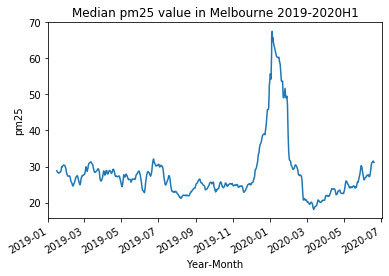

In [27]:
mel_air_specie("pm25")

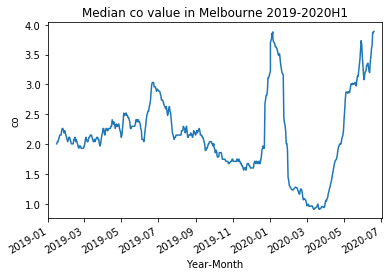

In [28]:
mel_air_specie("co")

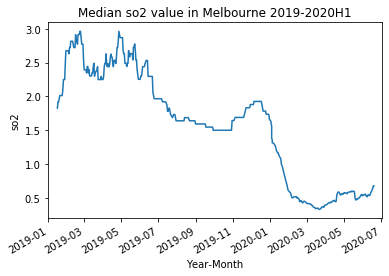

In [29]:
mel_air_specie("so2")

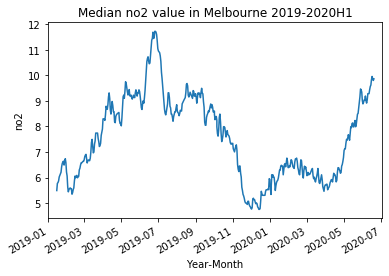

In [30]:
mel_air_specie("no2")

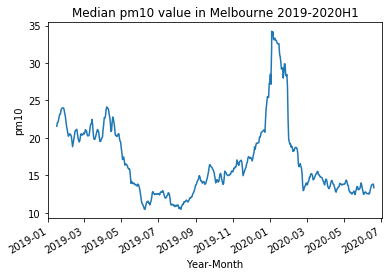

In [31]:
mel_air_specie("pm10")

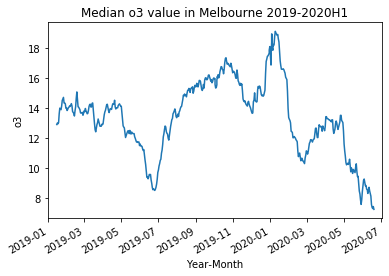

In [32]:
mel_air_specie("o3")

**"Unlike downsampling, where the time bins do not overlap and the output is at a lower frequency than the input, rolling windows overlap and “roll” along at the same frequency as the data, so the transformed time series is at the same frequency as the original time series."** (https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/)

* **Let's explore how air pollutant PM2.5 and CO change in Melbourne, Sydney and Perth.**

In [72]:
def specie_cities(df, city_list, specie):
    
    specie_cities_df = df[(df["City"].isin(city_list)) & (df["Specie"] == specie)].sort_values("Date").copy()
    specie_cities_transposed_df = specie_cities_df.pivot_table(index="Date", columns="City", values="median")
    rolling_specie_cities = specie_cities_transposed_df[city_list].rolling(7, center=True).mean()
    
    plt.style.use('seaborn-bright')
    ax = rolling_specie_cities.plot(figsize=(11.5, 7), title=f"Moving 7 day average of median {specie} in {city_list} in 2019-2020H1")
    ax.set_xlabel("Year-Month")
    ax.set_ylabel(specie)
    ax.set_xlim(starting_date, end_date)

In [33]:
au_air_df = clean_airdf.loc[clean_airdf["Country"]=="AU"]
au_air_df.head()

,Date,Country,City,Specie,count,min,max,median,variance
171319,2020-02-04,AU,Sydney,co,56,1.2,4.5,3.4,10.12
171320,2020-03-29,AU,Sydney,co,9,1.2,3.4,2.3,9.07
171321,2020-06-26,AU,Sydney,co,45,1.2,6.7,2.3,17.91
171322,2020-05-22,AU,Sydney,co,14,1.2,2.3,1.2,2.19
171323,2020-06-04,AU,Sydney,co,33,1.2,5.6,2.3,16.16


In [34]:
au_cities_list = ["Sydney", "Melbourne", "Perth"]

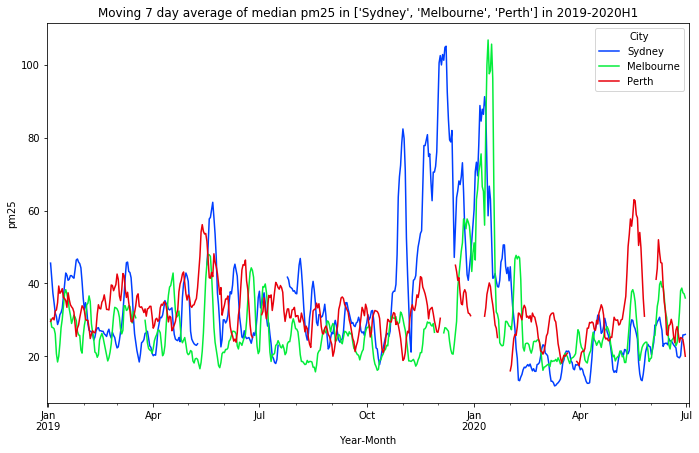

In [73]:
specie_cities(df=au_air_df, city_list=au_cities_list, specie="pm25")

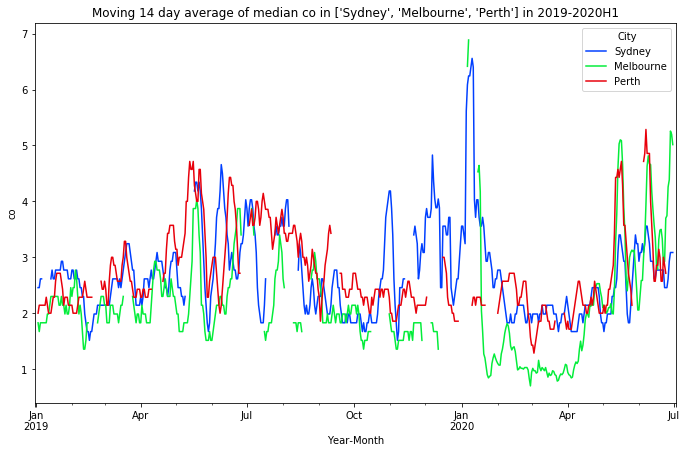

In [65]:
specie_cities(df=au_air_df, city_list=au_cities_list, specie="co")

###  Visualise air quality change in India (Mumbai, Delhi, Hyderabad) in 2019-2020H1

In [39]:
in_air_df = clean_airdf.loc[clean_airdf["Country"]=="IN"]
in_air_df.head()

,Date,Country,City,Specie,count,min,max,median,variance
422490,2020-02-24,IN,Thrissur,co,24,2.1,11.2,5.3,58.36
422491,2020-04-07,IN,Thrissur,co,72,2.3,13.6,8.1,131.11
422492,2020-04-24,IN,Thrissur,co,67,1.4,12.2,9.2,126.02
422493,2020-06-05,IN,Thrissur,co,72,0.7,26.8,14.1,532.05
422494,2020-06-13,IN,Thrissur,co,72,0.3,30.3,15.0,671.30


In [40]:
in_air_df["City"].value_counts()

Hyderabad             3384
Mumbai                3384
Jaipur                3384
Kolkata               3384
Bengaluru             3384
Delhi                 3384
Bhopal                3381
Ghāziābād             3348
Thiruvananthapuram    3307
Hāpur                 3306
Chandigarh            3218
Gandhinagar           3217
Nashik                3215
Visakhapatnam         3175
Muzaffarnagar         3123
Chennai               3000
Patna                 2975
Lucknow               2820
Shillong              2387
Thrissur              2255
Nagpur                1280
Mysore                1160
New Delhi              523
Name: City, dtype: int64

In [41]:
in_air_df["Specie"].value_counts()

pm25    11691
so2     11222
co      11203
o3      11192
no2     11154
pm10     9532
Name: Specie, dtype: int64

In [43]:
in_cities_list = ["Mumbai", "Delhi", "Hyderabad"]

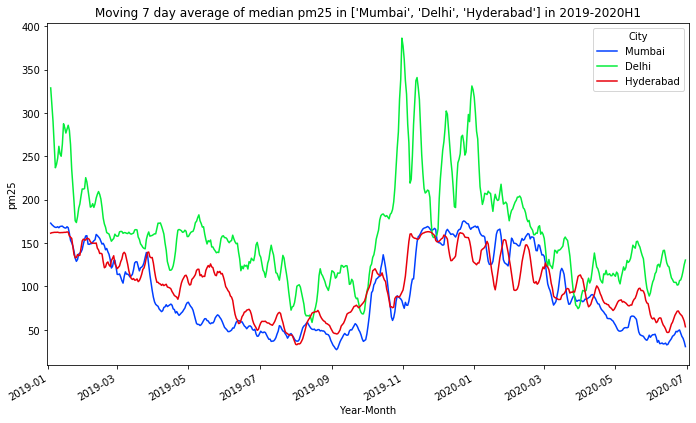

In [58]:
specie_cities(df=in_air_df, city_list=in_cities_list, specie="pm25")

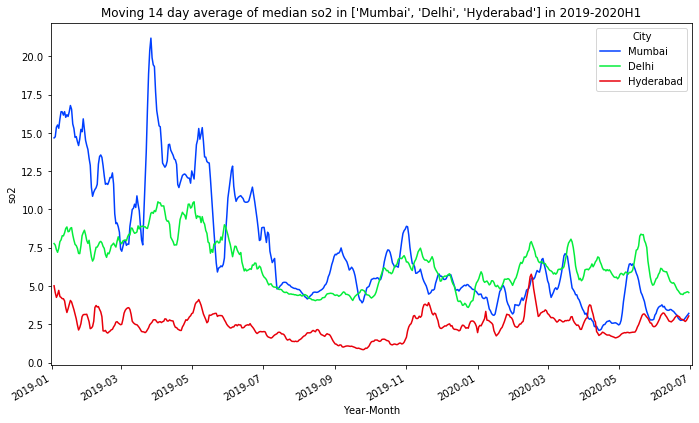

In [68]:
specie_cities(df=in_air_df, city_list=in_cities_list, specie="so2")

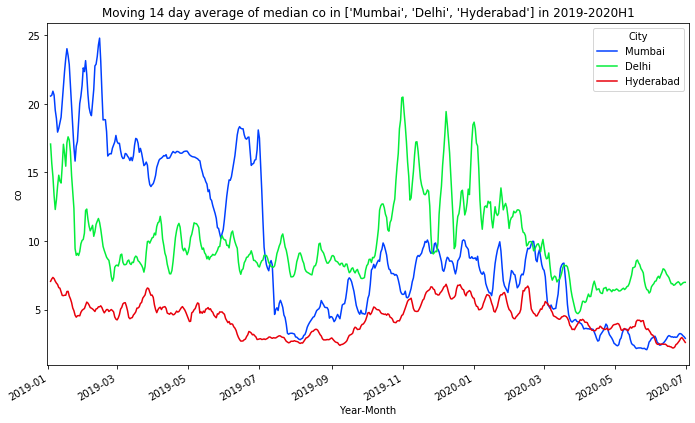

In [69]:
specie_cities(df=in_air_df, city_list=in_cities_list, specie="co")

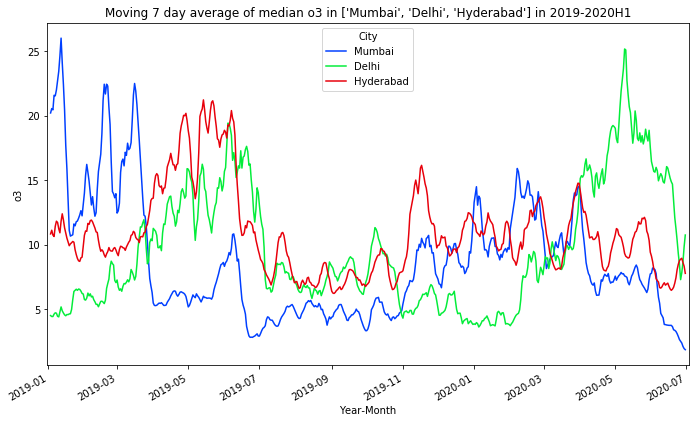

In [74]:
specie_cities(df=in_air_df, city_list=in_cities_list, specie="o3")

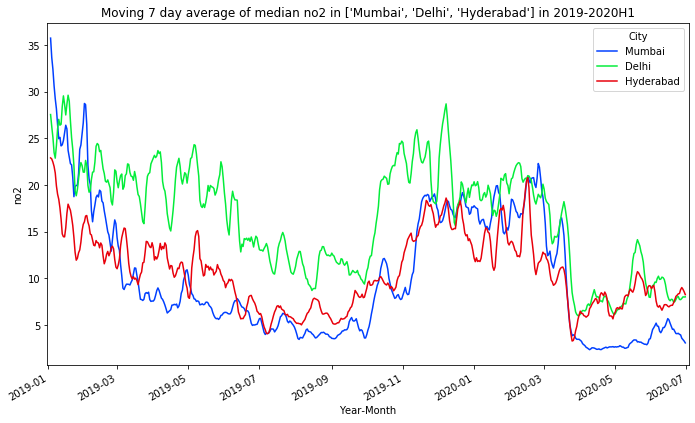

In [75]:
specie_cities(df=in_air_df, city_list=in_cities_list, specie="no2")

## COVID-19 in AUSTRALIA DATA EXPLORATION AND CLEAN UP

In [ ]:
au_covid_url = "https://interactive.guim.co.uk/docsdata/1q5gdePANXci8enuiS4oHUJxcxC13d6bjMRSicakychE.json"
au_covid_data = requests.get(au_covid_url).json()
pprint(au_covid_data)

In [ ]:
au_covid_data.keys()

In [ ]:
au_covid_data['sheets'].keys()

In [ ]:
covid_by_state = au_covid_data['sheets']['updates']
covid_by_state[50]

In [ ]:
state_list = list()
date_list = list()
cumulative_case_count = list()
cumulative_recovered_count = list()

for element in covid_by_state:
    state_list.append(element["State"])
    date_list.append(element["Date"])
    cumulative_case_count.append(element["Cumulative case count"])
    cumulative_recovered_count.append(element["Recovered (cumulative)"])

In [ ]:
au_covid_df = pd.DataFrame({
    "State": state_list,
    "Date": date_list,
    "Cumulative case count": cumulative_case_count,
    "Cumulative recovered count": cumulative_recovered_count
})
au_covid_df.head()

In [ ]:
au_covid_df.info()

In [ ]:
au_covid_df["Cumulative case count"] = pd.to_numeric(au_covid_df["Cumulative case count"].str.replace(",", ""))

In [ ]:
au_covid_df["Cumulative recovered count"] = pd.to_numeric(au_covid_df["Cumulative recovered count"].str.replace(",", ""))

In [ ]:
# Convert the Date column to datetime format
au_covid_df['Date'] = pd.to_datetime(au_covid_df["Date"], format= "%d/%m/%Y", errors='coerce')

In [ ]:
au_covid_df.info()

In [ ]:
# Find the earliest date the covid dataset covers:
au_covid_df["Date"].min()

In [ ]:
# Find the latrest date the covid dataset covers:
au_covid_df["Date"].max()

In [ ]:
# Set cutoff time on 5th July 2020 for the AU covid data
timebound_au_covid =  au_covid_df[au_covid_df["Date"] <= cut_off_date].copy()

In [ ]:
timebound_au_covid.info()

In [ ]:
timebound_au_covid.sort_values(["State", "Date"], inplace=True, ignore_index=True)
timebound_au_covid

In [ ]:
cols_to_fill = ["Cumulative case count", "Cumulative recovered count"]

timebound_au_covid[cols_to_fill]= timebound_au_covid.groupby("State")[cols_to_fill].fillna(method="ffill")

In [ ]:
timebound_au_covid.info()

In [ ]:
timebound_au_covid.fillna(0, inplace=True)

In [ ]:
timebound_au_covid.info()

In [ ]:
timebound_au_covid[cols_to_fill] = timebound_au_covid[cols_to_fill].astype(int)

In [ ]:
timebound_au_covid.info()

In [ ]:
clean_au_covid = timebound_au_covid.copy()

In [ ]:
clean_au_covid.tail(20)

In [ ]:
clean_au_covid["Active_cases"] = clean_au_covid["Cumulative case count"] - clean_au_covid["Cumulative recovered count"]

In [ ]:
clean_au_covid

In [ ]:
clean_au_covid['New case count'] = clean_au_covid.groupby(['State'])['Cumulative case count'].diff().fillna(0).astype(int)

In [ ]:
clean_au_covid

In [ ]:
vic_covid = clean_au_covid[clean_au_covid["State"]=="VIC"].set_index("Date")
vic_covid

In [ ]:
ax = vic_covid.plot(y="Active_cases", figsize=(15, 8), title="Number of active Covid-19 cases in Victoria 2020H1")
ax.set_ylabel("Number of active cases")
ax.set_xlabel("Year-Month")

In [ ]:
weekly_active_cases_vic_covid = vic_covid["Active_cases"].resample("W").sum().to_frame()
weekly_active_cases_vic_covid

In [ ]:
# Fill in dates to 
date_range_to_fill = pd.date_range(starting_date, "2020-01-19", freq="W").to_frame(name="Active_cases")
date_range_to_fill["Active_cases"]=0
date_range_to_fill

In [ ]:
time_matching_vic_covid_weekly_cases_df = pd.concat(
    [date_range_to_fill, weekly_active_cases_vic_covid]).reset_index().rename(columns={"index": "Date"})
time_matching_vic_covid_weekly_cases_df

In [ ]:
time_matching_vic_covid_weekly_cases_df.set_index("Date", inplace=True)

In [ ]:
time_matching_vic_covid_weekly_cases_df

## COVID-19 DATA EXPLORATION AND CLEAN UP

Covid-19 is sourced from here https://covid19api.com/

In [ ]:
country_url = "https://api.covid19api.com/countries"
country_covid_data = requests.get(country_url).json()
pprint(country_covid_data)

In [ ]:
country_covid_df = pd.DataFrame(country_covid_data)
country_covid_df

In [ ]:
# Merge countries available on the air quality data and the covid data
country_covid_air_df = pd.merge(
    country_airdata_df, country_covid_df, how="left", left_on="country_code", right_on="ISO2")
country_covid_air_df

In [ ]:
# Find the country in the country_airdata_df but not country_covid_df
country_to_remove = country_covid_air_df[country_covid_air_df["ISO2"].isna()]["country_code"].tolist()
country_to_remove

In [ ]:
final_airdf = clean_airdf[~clean_airdf["Country"].isin(country_to_remove)].copy()

In [ ]:
final_airdf["Country"].nunique()

In [ ]:
country_covid_air_df

In [ ]:
del country_covid_air_df["ISO2"]

In [ ]:
# Return a dataframe covering all countries in both the air quality data and covid-19 data.
country_covid_air_df = country_covid_air_df[~country_covid_air_df["country_code"].isin(
    country_to_remove)]
country_covid_air_df

In [ ]:
# Explore one covid API - By Country Total All Status
covid_url_example = "https://api.covid19api.com/total/country/australia"
covid_data_example = requests.get(covid_url_example).json()
pprint(covid_data_example)

The above api example covers covid-19 data until 4th July 2020. It also shows the number of confirmed, active, recovered, and death cases for each chosen country over the course of the current pandemic. Hence, we'll use this api to loop through our country_covid_air_df as above.

In [ ]:
slug_list = country_covid_air_df["Slug"].tolist()
len(slug_list)

In [ ]:
base_covid_url = "https://api.covid19api.com/total/country/"
    
country_list = list()
date_list = list()
active_list = list()
confirmed_list = list()
recovered_list = list()
deaths_list = list()

print("Beginning Data Retrieval")
print("-----------------------------------")

counter = 0
set_counter = 1

for slug in slug_list:
    
    try:
        response = requests.get(base_covid_url + slug).json()
    
        for element in response:
            country_list.append(element['Country'])
            date_list.append(element['Date'])
            active_list.append(element['Active'])
            confirmed_list.append(element['Confirmed'])
            recovered_list.append(element['Recovered'])
            deaths_list.append(element['Deaths'])

        counter += 1
        print(f"Processing Record {counter} of Set {set_counter} | {slug}")

        if counter == 50:
            set_counter += 1
            counter = 0

    except KeyError:
        print("Country not found. Skipping...")

print("-----------------------------------")
print("Data Retrieval Complete")
print("-----------------------------------")

In [ ]:
covid_df = pd.DataFrame({
    "Country": country_list,
    "Date": date_list,
    "Active cases": active_list,
    "Confirmed cases": confirmed_list,
    "Recovered cases": recovered_list,
    "Deaths": deaths_list
})
covid_df.head()

In [ ]:
covid_df.info()

In [ ]:
# Convert the Date column to datetime format
covid_df['Date'] = covid_df['Date'].astype('datetime64[ns]')

In [ ]:
# Find the earliest date the covid dataset covers:
covid_df["Date"].min()

In [ ]:
# Find the latrest date the covid dataset covers:
covid_df["Date"].max()

In [ ]:
# Set cutoff date to the latest date on the air quality data
world_covid_df = covid_df[covid_df["Date"] <= cut_off_date]

In [ ]:
world_covid_df.info()

In [ ]:
world_covid_df.tail(10)

In [ ]:
country_covid_air_df.head()

In [ ]:
world_covid_countrycode = pd.merge(world_covid_df, country_covid_air_df, how="left", on="Country")
world_covid_countrycode.head()

In [ ]:
clean_world_covid = world_covid_countrycode[["Date", "country_code", "Active cases"]].sort_values("Date")
clean_world_covid.head()

In [ ]:
clean_world_covid_transposed = clean_world_covid.pivot_table(index="Date", columns="country_code", values="Active cases")
clean_world_covid_transposed.head()

In [ ]:
clean_world_covid_transposed["Total active cases"] = clean_world_covid_transposed.sum(axis=1)
clean_world_covid_transposed.head()

In [ ]:
total_active_world_covid = clean_world_covid_transposed["Total active cases"].to_frame().reset_index()
total_active_world_covid.head()

In [ ]:
final_airdf.head(10)

In [ ]:
def world_air_covid_each_specie(specie):
    air_median_specie_transposed = final_airdf[final_airdf["Specie"] == specie].pivot_table(
        index="Date", columns="Country", values="median")

    air_median_specie_transposed[f"World Average {specie}"] = air_median_specie_transposed.mean(axis=1)

    final_air_median_specie_transposed = air_median_specie_transposed.iloc[:, -1].to_frame().reset_index()
    
    world_air_covid_median_specie = pd.merge(total_active_world_covid, final_air_median_specie_transposed, how="inner", on="Date")
    return world_air_covid_median_specie

In [ ]:
def linear_regression_plot(df_name, df, x, y):
    (slope, intercept, rvalue, pvalue, stderr) = linregress(df[x], df[y])
    regress_values = slope * df[x] + intercept

    line_eq = f"y = {round(slope, 2)}x + {round(intercept, 2)}"

    print(f"The correlation coefficient is: {rvalue}")
    print(f"The r-squared is: {rvalue**2}")

    plt.scatter(df[x], df[y], facecolors="dodgerblue", alpha=0.5)
    plt.plot(df[x], regress_values, "b--", linewidth=1)
    plt.annotate(line_eq, (df[x].median(), df[y].quantile(
        0.75)), fontsize=15, color="blue")
    plt.title(f"{df_name}world")
    plt.xlabel(x)
    plt.ylabel(y)
    plt.savefig(f"images/{df_name}linear.png")
    plt.show()

In [ ]:
world_air_covid_median_pm25 = world_air_covid_each_specie("pm25")
world_air_covid_median_pm25.head()

In [ ]:
linear_regression_plot("pm25", world_air_covid_median_pm25, x="Total active cases", y="World Average pm25")

In [ ]:
world_air_covid_median_co = world_air_covid_each_specie("co")
world_air_covid_median_co.head()

In [ ]:
linear_regression_plot("co", world_air_covid_median_co, x="Total active cases", y="World Average co")

In [ ]:
world_air_covid_median_no2 = world_air_covid_each_specie("no2")
world_air_covid_median_no2.head()

In [ ]:
linear_regression_plot("no2", world_air_covid_median_no2, x="Total active cases", y="World Average no2")

In [ ]:
world_air_covid_median_pm10 = world_air_covid_each_specie("pm10")
world_air_covid_median_pm10.head()

In [ ]:
linear_regression_plot("pm10", world_air_covid_median_pm10, x="Total active cases", y="World Average pm10")

In [ ]:
world_air_covid_median_o3 = world_air_covid_each_specie("o3")
world_air_covid_median_o3.head()

In [ ]:
linear_regression_plot("o3", world_air_covid_median_o3, x="Total active cases", y="World Average o3")

In [ ]:
world_air_covid_median_so2 = world_air_covid_each_specie("so2")
world_air_covid_median_so2.head()

In [ ]:
linear_regression_plot("so2", world_air_covid_median_so2, x="Total active cases", y="World Average so2")

In [ ]:
# import time
# from scipy.stats import linregress

# Incorporated citipy to determine city based on latitude and longitude
# from citipy import citipy

In [ ]:
# url = "https://api.openaq.org/v1/measurements"

# data = requests.get(url).json()
# pprint(data)

In [ ]:
# len(data["results"])

In [ ]:
# data["results"][0]

In [ ]:
# Data source: https://aqicn.org/api/
# base_url = "https://api.waqi.info/feed/"
# city = "melbourne"
# url = f"{base_url}{city}/?token={api_key}"

In [ ]:
# url_2 = "https://api.covid19api.com/country/south-africa/status/confirmed/live"
# covid_data_2 = requests.get(url_2).json()
# pprint(covid_data_2[-1])